# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). This model achives our best perplexity yet, ~27 compared to ~34 for the previous model.

## Introduction

As a reminder, here is the general encoder-decoder model:

![](https://github.com/SethHWeidman/pytorch-seq2seq/blob/master/assets/seq2seq1.png?raw=1)

In the previous model, our architecture was set-up in a way to reduce "information compression" by explicitly passing the context vector, $z$, to the decoder at every time-step and by passing both the context vector and input word, $y_t$, along with the hidden state, $s_t$, to the linear layer, $f$, to make a prediction.

![](https://github.com/SethHWeidman/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

Even though we have reduced some of this compression, our context vector still needs to contain all of the information about the source sentence. The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? It uses *attention*. 

Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. 

$$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the tutorial.

## Preparing Data

Again, the preparation is similar to last time.

First we import all the required modules.

In [1]:
!pip install comet_ml

     |████████████████████████████████| 174kB 2.9MB/s 
     |████████████████████████████████| 409kB 8.2MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34546 sha256=70bdd55535dbeca483ce94c62a89a63eca7ea75bfc4be717061853a09934174e
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj
  Found existing installation: jsonschema 3.2.0
    Uninstalling jsonschema-3.2.0:
      Successfully uninstalled jsonschema-3.2.0


In [2]:
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

from torchtext.datasets import TranslationDataset, Multi30k, IWSLT
from torchtext.data import Field, BucketIterator

In [3]:
import spacy
import os
import numpy as np
from typing import Tuple
import random
import math
import time

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/translation-en-to-de/EN-to-DE-model-ISWLT.pt
/kaggle/input/en-to-de/__results__.html
/kaggle/input/en-to-de/__notebook__.ipynb
/kaggle/input/en-to-de/custom.css
/kaggle/input/en-to-de/__output__.json
/kaggle/input/en-to-de/__results___files/__results___18_0.png


Set the random seeds for reproducability.

In [5]:
SEED = 1001

def seed_torch(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(SEED)

In [6]:
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.6/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 4.2MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=675f5e2c5dd478b222c6363d087b5a1c1a917ea50d6b18ae56150c26a7703603
  Stored in directory: /tmp/pip-ephem-wheel-cache-reb2n5oa/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/opt/conda/lib/python3.6/site-packages/de_core_news_sm -->
/opt/conda/lib/python3.6/site-packages/spacy/data/de
You can now load the model via spacy.load('de')


Load the German and English spaCy models.

In [7]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

We create the tokenizers.

In [8]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [9]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TGT = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Load the data.

In [10]:
train_data, valid_data, test_data = IWSLT.splits(exts = ('.en', '.de'), 
                                                fields = (SRC, TGT),
                                                filter_pred=lambda x: len(vars(x)['src']) <=200 
                                                and len(vars(x)['trg']) <= 200)

downloading en-de.tgz


en-de.tgz: 100%|██████████| 23.6M/23.6M [00:03<00:00, 5.94MB/s]


.data/iwslt/en-de/IWSLT16.TED.tst2010.en-de.de.xml
.data/iwslt/en-de/IWSLT16.TED.tst2013.en-de.en.xml
.data/iwslt/en-de/IWSLT16.TED.dev2010.en-de.en.xml
.data/iwslt/en-de/IWSLT16.TED.dev2010.en-de.de.xml
.data/iwslt/en-de/IWSLT16.TED.tst2012.en-de.en.xml
.data/iwslt/en-de/IWSLT16.TED.tst2012.en-de.de.xml
.data/iwslt/en-de/IWSLT16.TED.tst2014.en-de.de.xml
.data/iwslt/en-de/IWSLT16.TED.tst2014.en-de.en.xml
.data/iwslt/en-de/IWSLT16.TED.tst2013.en-de.de.xml
.data/iwslt/en-de/IWSLT16.TED.tst2010.en-de.en.xml
.data/iwslt/en-de/IWSLT16.TED.tst2011.en-de.de.xml
.data/iwslt/en-de/IWSLT16.TED.tst2011.en-de.en.xml
.data/iwslt/en-de/train.tags.en-de.en
.data/iwslt/en-de/train.tags.en-de.de


Build the vocabulary.

In [11]:
SRC.build_vocab(train_data, min_freq = 2)
TGT.build_vocab(train_data, min_freq = 2)

In [12]:
print(len(SRC.vocab))
print(len(TGT.vocab))

32826
56052


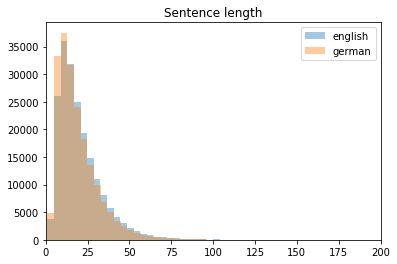

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot([len(_) for _ in list(train_data.src)], kde=False, label='english')
sns.distplot([len(_) for _ in list(train_data.trg)], kde=False, label='german')
plt.xlim([0, 200])
plt.title('Sentence length')
plt.legend();

Define the device.

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create the iterators.

In [15]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

## Building the Seq2Seq Model

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the sentence from left to right (shown below in green), and a *backward RNN* going over the sentence from right to left (yellow). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

![](https://github.com/SethHWeidman/pytorch-seq2seq/blob/master/assets/seq2seq8.png?raw=1)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(x_t^\rightarrow,h_t^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(x_t^\leftarrow,h_t^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src sent len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. You can think of the third axis as being the forward and backward hidden states stacked on top of each other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all stacked encoder hidden states as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so I've changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [16]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 emb_dim: int, 
                 enc_hid_dim: int, 
                 dec_hid_dim: int, 
                 dropout: float):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, 
                src: Tensor) -> Tuple[Tensor]:
        
        #src = [src sent len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        # Note: torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        # is of shape [batch_size, enc_hid_dim * 2]
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, attn dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of this as calculating a weighted sum of the "match" over all `dec_hid_dem` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](https://github.com/SethHWeidman/pytorch-seq2seq/blob/master/assets/seq2seq9.png?raw=1)

In [17]:
class Attention(nn.Module):
    def __init__(self, 
                 enc_hid_dim: int, 
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim
        
        self.attn = nn.Linear(self.attn_in, attn_dim)
        self.v = nn.Parameter(torch.rand(attn_dim))
        
    def forward(self, 
                decoder_hidden: Tensor, 
                encoder_outputs: Tensor) -> Tensor:
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #decoder_hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        # Step 1: to enable feeding through "self.attn" pink box above, concatenate 
        # `repeated_decoder_hidden` and `encoder_outputs`:
        # torch.cat((hidden, encoder_outputs), dim = 2) has shape 
        # [batch_size, seq_len, enc_hid_dim * 2 + dec_hid_dim]
        
        # Step 2: feed through self.attn to end up with:
        # [batch_size, seq_len, attn_dim]
        
        # Step 3: feed through tanh       
        
        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden, 
            encoder_outputs), 
            dim = 2))) 
        
        #energy = [batch size, src sent len, attn_dim]
        
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, attn_dim, src sent len]
        
        #v = [attn_dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, attn_dim]
        
        # High level: energy a function of both encoder element outputs and most recent decoder hidden state,
        # of shape attn_dim x enc_seq_len for each observation
        # v, being 1 x attn_dim, transforms this into a vector of shape 1 x enc_seq_len for each observation
        # Then, we take the softmax over these to get the output of the attention function

        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word (that has been embedded), $y_t$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(y_t, w_t, s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](https://github.com/SethHWeidman/pytorch-seq2seq/blob/master/assets/seq2seq10.png?raw=1)

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [18]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim: int, 
                 emb_dim: int, 
                 enc_hid_dim: int, 
                 dec_hid_dim: int, 
                 dropout: int, 
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        # Note: from Attention: self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, attn_dim)
        
        # Note: `output_dim` same as `vocab_size`
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def _weighted_encoder_rep(self, 
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor) -> Tensor:
        
        # Attention, at a high level, takes in:
        # The decoder hidden state
        # All the "seq_len" encoder outputs
        # Outputs a vector summing to 1 of length seq_len for each observation
        a = self.attention(decoder_hidden, encoder_outputs)

        #a = [batch size, src len]

        a = a.unsqueeze(1)

        #a = [batch size, 1, src len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        #weighted_encoder_rep = [batch size, 1, enc hid dim * 2]

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        #weighted_encoder_rep = [1, batch size, enc hid dim * 2]
        
        return weighted_encoder_rep
        
        
    def forward(self, 
                input: Tensor, 
                decoder_hidden: Tensor, 
                encoder_outputs: Tensor) -> Tuple[Tensor]:
             
        #input = [batch size] Note: "one character at a time"
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden, 
                                                          encoder_outputs)
        
        # Then, the input to the decoder _for this character_ is a concatenation of:
        # This weighted attention
        # The embedding itself
        
        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #decoder_hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == decoder_hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)
        
        output = self.out(torch.cat((output, 
                                     weighted_encoder_rep, 
                                     embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, decoder_hidden.squeeze(0)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the encoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the decoding steps:

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder: nn.Module, 
                 decoder: nn.Module, 
                 device: torch.device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, 
                src: Tensor, 
                trg: Tensor, 
                teacher_forcing_ratio: float = 0.5) -> Tensor:
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        for t in range(1, max_len):
            output, hidden = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)

        return outputs

## Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TGT.vocab)

ENC_EMB_DIM = 32
DEC_EMB_DIM = 32
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [21]:
def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(32826, 32)
    (rnn): GRU(32, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=192, out_features=8, bias=True)
    )
    (embedding): Embedding(56052, 32)
    (rnn): GRU(160, 64)
    (out): Linear(in_features=224, out_features=56052, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

Note also that the model with modified attention has slightly fewer parameters.

In [22]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,546,628 trainable parameters


We create an optimizer.

In [23]:
optimizer = optim.Adam(model.parameters())

We initialize the loss function.

In [24]:
PAD_IDX = TGT.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

We then create the training loop...

In [25]:
api = 'GGF21Vtrnid3Cgat9n1nL9Vcc'
experiment = Experiment(api_key=api, project_name="EN to DE RNN with attention", workspace="comet-ml testing")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/en-to-de-rnn-with-attention/9f3dd11084684ccda433b6a068391fa8



In [26]:
def train(model: nn.Module,
          iterator: BucketIterator,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):
 
    model.train()
 
    epoch_loss = 0
    for _, batch in enumerate(iterator):
 
        src = batch.src
        trg = batch.trg
 
        optimizer.zero_grad()
 
        output = model(src, trg)
 
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
 
        loss = criterion(output, trg)
       
        experiment.log_metric("train loss", loss.item())
       
        loss.backward()
 
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
 
        optimizer.step()
 
        epoch_loss += loss.item()
 
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [27]:
def evaluate(model: nn.Module,
             iterator: BucketIterator,
             criterion: nn.Module):
 
    model.eval()
 
    epoch_loss = 0
 
    with torch.no_grad():
 
        for _, batch in enumerate(iterator):
 
            src = batch.src
            trg = batch.trg
 
            output = model(src, trg, 0) #turn off teacher forcing
 
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
 
            loss = criterion(output, trg)
 
            epoch_loss += loss.item()
 
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [28]:
def epoch_time(start_time: int, 
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [29]:
MODEL_PATH = 'EN-to-DE-model-ISWLT.pt'

In [30]:
src = 'Do you want a cup of coffee?'
trg = 'Möchtest du eine Tasse Kaffee?'

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')


SOS_DE = TGT.vocab.stoi['<sos>']
EOS_DE = TGT.vocab.stoi['<eos>']

MAX_LEN = 30

def translate(model, src):
    model.eval()
    
    src = ['<sos>'] + tokenize_en(src.lower()) + ['<eos>']
    src = [SRC.vocab.stoi[el] for el in src]
    #print(src)
    
    src = torch.tensor(src, device=device).unsqueeze(1)
    
    encoder_outputs, hidden = model.encoder(src)
    
    # first input to the decoder is the <sos> token
    output = torch.tensor([SOS_DE], device=device)
    
    trg_vocab_size = model.decoder.output_dim
    outputs = torch.zeros(MAX_LEN, 1, trg_vocab_size).to(device)
    
    translation = ''
    for t in range(1, MAX_LEN):
        translation += TGT.vocab.itos[output]
        translation += ' '
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        output, hidden = model.decoder(output, hidden, encoder_outputs)
        outputs[t] = output
        output = output.max(1)[1]
        if output == EOS_DE:
            translation += TGT.vocab.itos[output]
            return translation
    return translation
        

In [31]:
model.load_state_dict(torch.load('/kaggle/input/translation-en-to-de/EN-to-DE-model-ISWLT.pt'))

N_EPOCHS = 4
CLIP = 1

best_valid_loss = 4.6

for epoch in range(N_EPOCHS):
    start_time = time.time()
 
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    experiment.log_metric("validation loss", train_loss)
    experiment.log_metric("epoch", epoch)
    
    end_time = time.time()
 
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
 
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_PATH)
       
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    translation = translate(model, src)
    experiment.log_text("EN src: " + src + "\n" + "DE trg: " + trg + "\n" + "DE res: " + translation)
    experiment.log_epoch_end(N_EPOCHS)

experiment.end()


Epoch: 01 | Time: 72m 45s
	Train Loss: 4.521 | Train PPL:  91.935
	 Val. Loss: 4.570 |  Val. PPL:  96.570
Epoch: 02 | Time: 72m 57s
	Train Loss: 4.388 | Train PPL:  80.473
	 Val. Loss: 4.542 |  Val. PPL:  93.918
Epoch: 03 | Time: 72m 38s
	Train Loss: 4.289 | Train PPL:  72.880
	 Val. Loss: 4.507 |  Val. PPL:  90.674


COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/en-to-de-rnn-with-attention/9f3dd11084684ccda433b6a068391fa8
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [4]                      : (0.0, 3.0)
COMET INFO:     loss [1231]                    : (3.7710113525390625, 4.975497722625732)
COMET INFO:     sys.cpu.percent.01 [257]       : (38.7, 60.5)
COMET INFO:     sys.cpu.percent.02 [257]       : (46.8, 69.7)
COMET INFO:     sys.cpu.percent.avg [257]      : (52.2, 55.099999999999994)
COMET INFO:     sys.gpu.0.free_memory [291]    : (457048064.0, 16256991232.0)
COMET INFO:     sys.gpu.0.gpu_utilization [291]: (0.0, 93.0)
COMET INFO:     sys.gpu.0.total_memory         : (17071734784.0, 17071734784.0)
COMET INFO:     sys.gpu.0.used_memory [291]    : (814743552.0, 16614686720.0)
COMET INFO:     sys.load.avg [257]             : (1.0, 2.61)
COMET INFO:     sys.ram.total

Epoch: 04 | Time: 72m 56s
	Train Loss: 4.209 | Train PPL:  67.274
	 Val. Loss: 4.505 |  Val. PPL:  90.488


COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


Finally, we test the model on the test set using these "best" parameters.

In [32]:
model.load_state_dict(torch.load(MODEL_PATH))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.713 | Test PPL: 111.339 |


In [33]:
translate(model, src)

'<sos> haben sie einen kaffee ? ? <eos>'